In [3]:
# 必要package
import numpy as np
import pandas as pd
import bilby
from bilby.gw.conversion import luminosity_distance_to_redshift
from bilby.gw.conversion import redshift_to_luminosity_distance
from astropy.cosmology import Planck18 as cosmo

# 非必要
from gwpy.time import Time as GWTime
import matplotlib.pyplot as plt
from scipy.signal import welch

# 0. 参数设置
## 所有可以更改的参数均在这个单元
### 0.0 随机种子

In [3]:
# random seed 
n=613  

### 0.1 源参数
### 设置单元格1.1中波源参数的采样范围
n_samples: 总样本个数

z：波源红移 (建议范围 0 < z_s <= 2)

d_L：波源光度距离

m：波源质量（建议范围 10 - 70）

time：波形到达时间

其余参数使用默认即可


In [ ]:
# 总样本个数
n_samples=200

# 源红移范围 
z_min=0.01
z_max=2
d_L_min = redshift_to_luminosity_distance(z_min, cosmology=cosmo)
d_L_max = redshift_to_luminosity_distance(z_max, cosmology=cosmo)

# 源质量范围
m_min=10
m_max=70

# 波形到达地心时间范围，可自定义时间段
time_start = GWTime('2015-09-14 09:50:45.39', scale='utc').gps
time_end=GWTime('2025-08-04 20:18:45.39', scale='utc').gps

### 0.2 透镜参数
### 从n_samples个波源中，随机挑选n_lens个，作为被透镜化的GW波源
### 如果不需要生成透镜化数据，设为0即可
### 运行此单元格，所有透镜参数保存至文件 lens_params.csv
n_lens: 透镜化样本个数( <=n_samples)

mu_0：第一个像的放大率( mu_0 > 2 )

mu_1：第二个像的放大率

t_d：第二个像与第一个像的到达时间差( t_d > 0 )

In [ ]:
#透镜化样本个数（小于等于 n_samples）
n_lens=10

# SIS放大率及时延(sigmav=250,beta_x=0.1,beta_y=0)
# 可根据实际需要调整数值，建议在这个范围内设置
mu_0_min=2.5
mu_0_max=10
t_d_min=19298.97772507615
t_d_max=8754164.429844286

# 可根据实际需要调整分布
mu_0=np.linspace(mu_0_min,mu_0_max,n_lens)
t_d=np.linspace(t_d_max,t_d_min,n_lens)  
mu_1=2-mu_0 

lens = {'mu_0': mu_0, 'mu_1': mu_1, 't_d': t_d}

lens = pd.DataFrame(lens)
lens.to_csv('lens_params.csv', index=False)
lens


,mu_0,mu_1,t_d
0,2.500000,-0.500000,8.754164e+06
1,3.333333,-1.333333,7.783624e+06
2,4.166667,-2.166667,6.813083e+06
3,5.000000,-3.000000,5.842543e+06
4,5.833333,-3.833333,4.872002e+06
5,6.666667,-4.666667,3.901461e+06
6,7.500000,-5.500000,2.930921e+06
7,8.333333,-6.333333,1.960380e+06
8,9.166667,-7.166667,9.898396e+05
9,10.000000,-8.000000,1.929898e+04


### 0.3 GW波形参数
### 设置波形的采样频率以及数据时长
sampling_frequency: 采样频率(建议 >=4096Hz)

duration: 数据时长(建议 >16s,太短可能无法容纳GW波形.如果实在需要更短的data,可以增大minimum_frequency)

minimum_frequency: 引力波波形的起始频率(建议20Hz-40HZ)

In [6]:
sampling_frequency=4096  # f_s >= 2*f_max   #
duration=16  # len(strain_data) = f_s*duration
minimum_frequency=20.0

# 1. Source generation
## 1.1 All GW sources
### 使用bilby内置先验分布对GW参数进行采样，产生n_samples个源
### 运行此单元格，保存所有波源参数至文件 source_samples.csv

dict_keys(['luminosity_distance', 'mass_1_source', 'mass_2_source', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'ra', 'dec', 'theta_jn', 'psi', 'phase', 'geocent_time'])


,luminosity_distance,mass_1_source,mass_2_source,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,ra,dec,theta_jn,psi,phase,geocent_time
0,13962.431078,53.756306,40.024735,0.040449,0.203610,2.221683,2.183540,1.975013,1.131382,5.104502,-0.415555,1.522255,1.083717,5.058207,1.409237e+09
1,13531.895001,61.366383,37.161695,0.668956,0.315031,1.066093,1.300889,1.987602,3.757037,5.002593,0.921503,1.786901,3.050658,0.554481,1.327031e+09
2,13066.305881,50.645492,37.596146,0.471805,0.147768,1.499701,1.279450,2.843236,0.928940,5.636801,-0.810247,2.187619,0.280511,0.582076,1.387005e+09
3,9577.944430,58.242131,10.493023,0.939399,0.313308,2.184714,0.659766,6.060366,0.454381,5.176854,-0.049457,2.415790,2.791314,5.058417,1.359567e+09
4,12033.869918,35.544996,31.062617,0.297929,0.772100,2.163774,1.512254,5.236850,2.897299,5.792183,-1.177310,1.427225,2.703351,6.045831,1.342054e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8630.608758,33.466146,49.954857,0.555313,0.973806,1.334957,1.039123,2.163962,2.106161,2.330141,0.360506,1.641992,2.113890,1.697710,1.394455e+09
196,14250.976157,34.796930,29.371618,0.543093,0.924546,2.838729,0.541304,2.086983,1.507268,5.802569,-0.146051,0.503325,2.689917,4.844082,1.181180e+09
197,11326.748583,44.501689,15.059185,0.443307,0.972603,2.145055,1.788751,4.415238,3.999830,3.935248,1.444658,0.341402,0.605888,4.325326,1.239158e+09
198,6194.021361,44.708734,60.149189,0.084915,0.113752,2.541969,0.816818,5.159663,5.447404,1.166392,-0.317016,2.392774,1.552592,0.889889,1.281134e+09


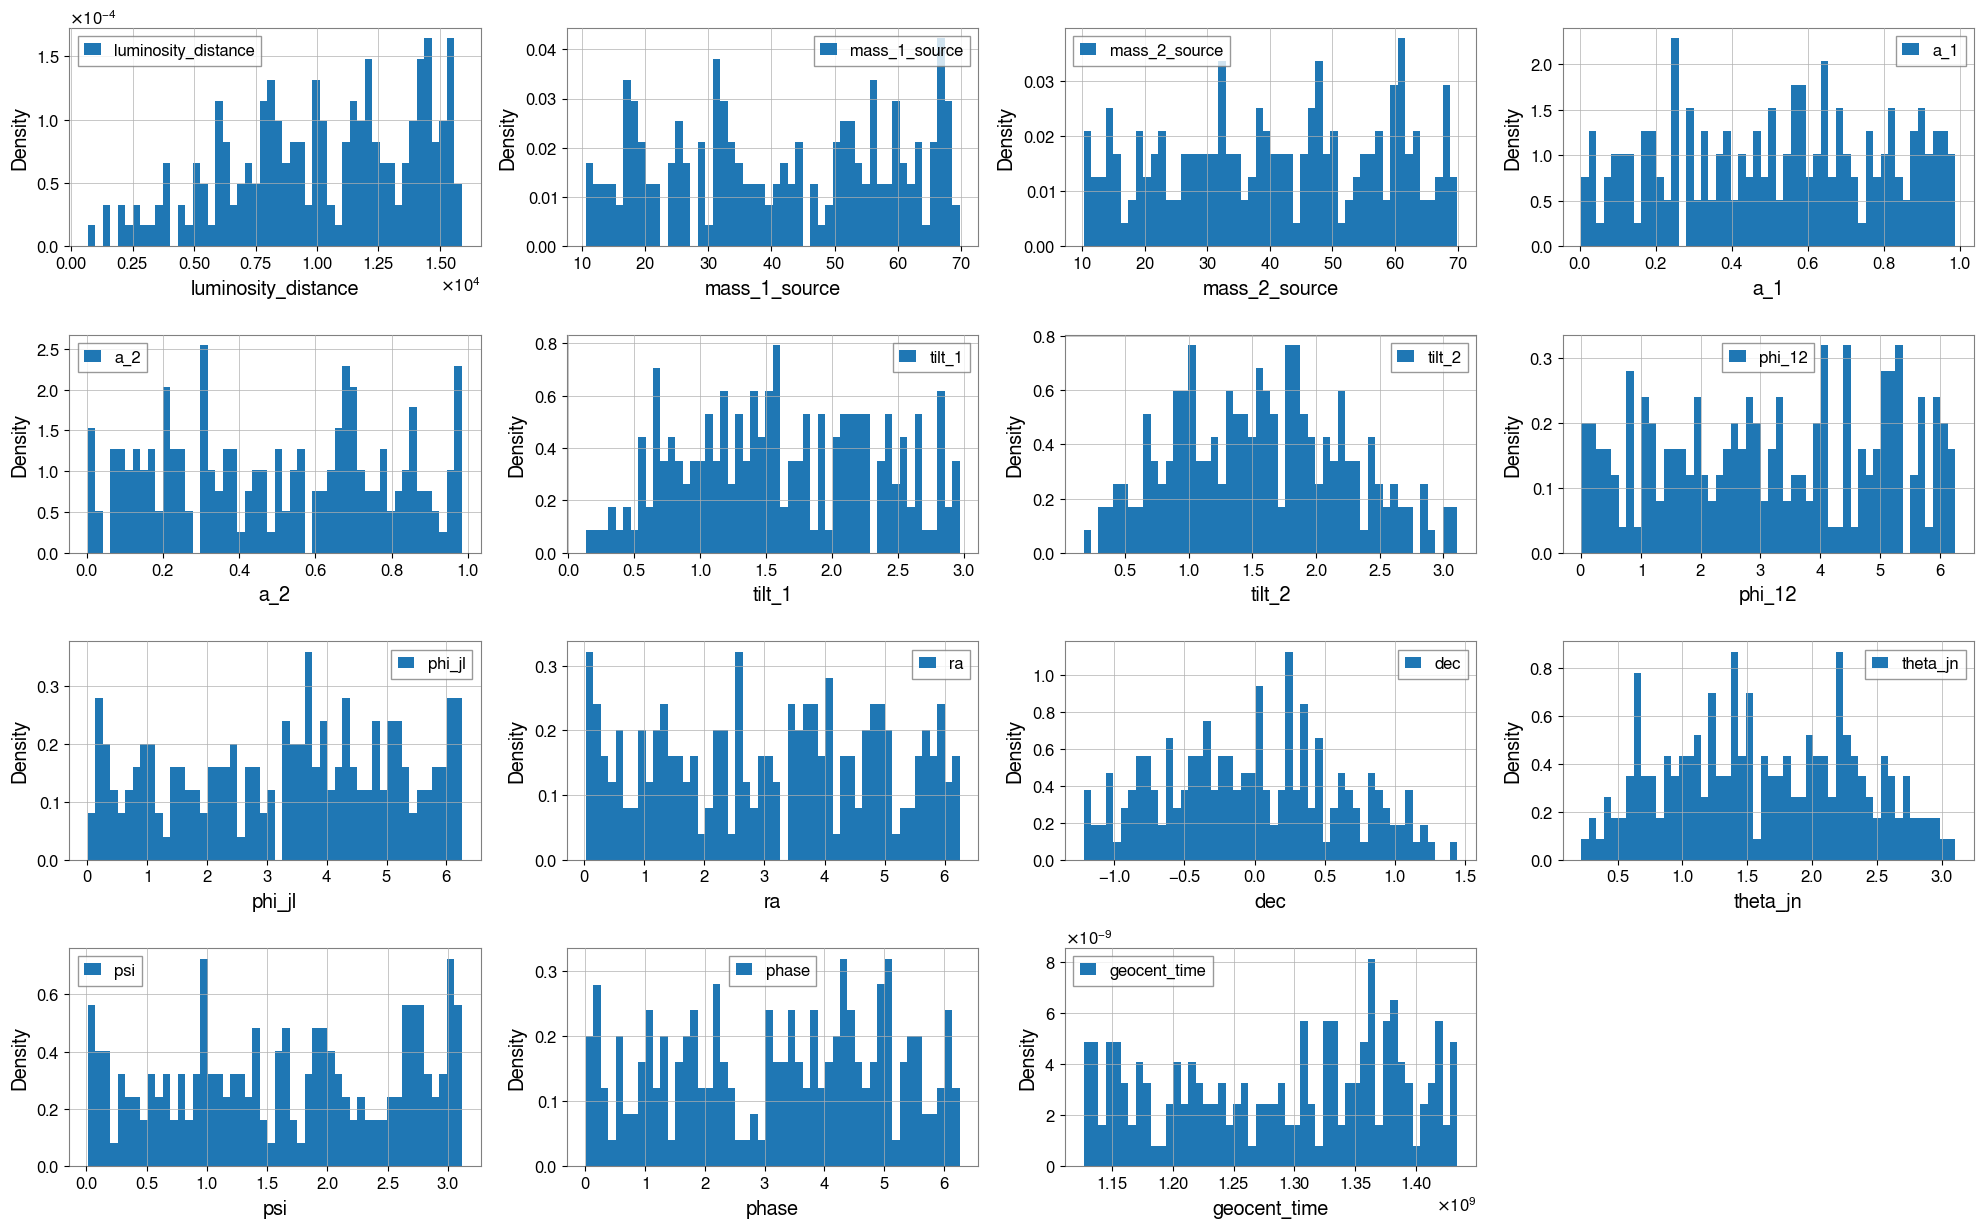

In [7]:
bilby.core.utils.random.seed(n)


# sampling from priors
def prior_GW():
    priors = bilby.core.prior.PriorDict()
    priors['luminosity_distance']=bilby.gw.prior.UniformComovingVolume(
        name="luminosity_distance", minimum=d_L_min, maximum=d_L_max, latex_label="r'$d_L$ (Mpc)'")
    priors['mass_1_source']= bilby.core.prior.Uniform(m_min, m_max, 'mass_1_source')
    priors['mass_2_source']= bilby.core.prior.Uniform(m_min, m_max, 'mass_2_source')
    priors['a_1']= bilby.core.prior.Uniform(0, 0.99, 'a_1')
    priors['a_2']= bilby.core.prior.Uniform(0, 0.99, 'a_2')
    priors['tilt_1']= bilby.core.prior.Sine(name='tilt_1')
    priors['tilt_2']= bilby.core.prior.Sine(name='tilt_2')
    priors['phi_12']= bilby.core.prior.Uniform(0, 2 * np.pi, 'phi_12', boundary='periodic')
    priors['phi_jl']= bilby.core.prior.Uniform(0, 2 * np.pi, 'phi_jl', boundary='periodic')
    priors['ra']= bilby.core.prior.Uniform(0, 2 * np.pi, 'ra', boundary='periodic')
    priors['dec']= bilby.core.prior.Cosine(name='dec')
    priors['theta_jn']= bilby.core.prior.Sine(name='theta_jn')
    priors['psi']= bilby.core.prior.Uniform(0, np.pi, 'psi', boundary='periodic')
    priors['phase']= bilby.core.prior.Uniform(0, 2 * np.pi, 'phase', boundary='periodic')
    priors['geocent_time']= bilby.core.prior.Uniform(time_start, time_end, 'geocent_time')

    return priors

priors = prior_GW()
samples = priors.sample(n_samples)
print(samples.keys())

fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()
for i, key in enumerate(samples.keys()):
    ax = axes[i]
    ax.hist(samples[key], bins=50, density=True, label=key)
    ax.set_xlabel(key)
    ax.set_ylabel('Density')
    ax.legend()
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
# plt.savefig('source_samples.pdf')


# 保存数据
source_params = pd.DataFrame(samples)
source_params.to_csv('source_samples.csv', index=False)
source_params

## 1.2 Lensed GW source
### 从n_samples个波源中，随机挑选n_lens个，作为被透镜化的GW波源
### 运行此单元格，得到需要透镜化的波源(第一个像的参数),并保存其在所有波源中的index至文件 lensed_index.csv

In [8]:
source_params=pd.read_csv('source_samples.csv')

np.random.seed(n)
idx = np.random.choice(n_samples, n_lens, replace=False)
print(idx)
idx={'lensed_index': idx}
lensed_index=pd.DataFrame(idx)
lensed_index.to_csv('lensed_index.csv', index=False)
lensed_index

lensed_source_1 = source_params.iloc[lensed_index['lensed_index']]
# lensed_source_1.to_csv('lensed_source_1.csv', index=False)
lensed_source_1

[129 117  18  23  71 196  89 118  25 137]


,luminosity_distance,mass_1_source,mass_2_source,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,ra,dec,theta_jn,psi,phase,geocent_time
129,14417.808015,46.238753,34.573239,0.587402,0.038444,1.012021,1.839950,4.995777,4.533788,0.201334,-0.524056,2.219313,1.671752,2.731503,1.368349e+09
117,8721.122768,42.344047,17.467521,0.141398,0.010567,1.454491,2.081916,0.029592,2.829806,1.250304,1.196631,1.134605,2.750070,0.244817,1.218220e+09
18,9438.292520,30.934611,42.560710,0.879391,0.203273,0.869685,2.496124,1.208982,4.281199,3.990995,-1.179348,0.986450,1.004736,2.350522,1.234085e+09
23,14066.189650,48.671861,21.338765,0.798407,0.135188,1.403728,1.939451,4.638783,5.042801,0.371667,-0.868146,0.670297,0.945665,6.095721,1.381822e+09
71,15377.990589,29.865859,20.663007,0.040745,0.925046,2.025994,2.013453,0.105693,6.257214,5.515964,0.493527,0.762929,1.912396,0.281446,1.136757e+09
196,14250.976157,34.796930,29.371618,0.543093,0.924546,2.838729,0.541304,2.086983,1.507268,5.802569,-0.146051,0.503325,2.689917,4.844082,1.181180e+09
89,10326.173197,14.525417,52.267633,0.835950,0.088968,1.497556,0.645042,3.020087,4.434336,3.514706,0.452423,2.537929,0.408063,3.043399,1.250212e+09
118,9948.867457,51.654164,46.037650,0.592353,0.864985,2.028662,2.209093,2.785968,1.425590,3.749184,0.345019,2.411542,1.784354,4.885112,1.278623e+09
25,12144.418899,26.680298,37.813738,0.516414,0.086150,0.741586,0.835908,2.939684,2.198111,0.482581,-0.205869,0.715832,2.382898,4.324509,1.213872e+09
137,11851.362153,33.142826,53.357854,0.575524,0.173640,2.457754,1.565965,4.049580,6.102237,3.480444,-0.710364,1.212905,1.380131,3.493123,1.378177e+09


## 1.3 All lensed GW source
### 透镜产生双像，所以n_lens个透镜会产生 2 * n_lens个像，相当于有 2 * n_lens组源的参数和data
### 运行此单元格，产生第二个像的源参数（t_2=t_1+t_d，其余参数保持一致）,保存所有透镜化GW源的参数至文件 lensed_source_samples.csv

In [10]:
t_d=[]
for i in range(len(lens)):
    t_d.append((lens['t_d'][i]))
print(t_d)

original_times = lensed_source_1['geocent_time'].values
# print(original_times)

geocent_time_2 = original_times + t_d
# print(geocent_time_2)

lensed_source_2 = lensed_source_1.copy()
lensed_source_2['geocent_time'] = geocent_time_2

lensed_source_params = pd.concat([lensed_source_1, lensed_source_2], axis=0, ignore_index=False)
lensed_source_params.to_csv('lensed_source_samples.csv', index=False)

lensed_source_params

[8754164.429844286, 7783623.824053263, 6813083.218262239, 5842542.612471215, 4872002.006680192, 3901461.4008891694, 2930920.7950981455, 1960380.1893071216, 989839.5835160986, 19298.97772507615]


,luminosity_distance,mass_1_source,mass_2_source,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,ra,dec,theta_jn,psi,phase,geocent_time
129,14417.808015,46.238753,34.573239,0.587402,0.038444,1.012021,1.839950,4.995777,4.533788,0.201334,-0.524056,2.219313,1.671752,2.731503,1.368349e+09
117,8721.122768,42.344047,17.467521,0.141398,0.010567,1.454491,2.081916,0.029592,2.829806,1.250304,1.196631,1.134605,2.750070,0.244817,1.218220e+09
18,9438.292520,30.934611,42.560710,0.879391,0.203273,0.869685,2.496124,1.208982,4.281199,3.990995,-1.179348,0.986450,1.004736,2.350522,1.234085e+09
23,14066.189650,48.671861,21.338765,0.798407,0.135188,1.403728,1.939451,4.638783,5.042801,0.371667,-0.868146,0.670297,0.945665,6.095721,1.381822e+09
71,15377.990589,29.865859,20.663007,0.040745,0.925046,2.025994,2.013453,0.105693,6.257214,5.515964,0.493527,0.762929,1.912396,0.281446,1.136757e+09
196,14250.976157,34.796930,29.371618,0.543093,0.924546,2.838729,0.541304,2.086983,1.507268,5.802569,-0.146051,0.503325,2.689917,4.844082,1.181180e+09
89,10326.173197,14.525417,52.267633,0.835950,0.088968,1.497556,0.645042,3.020087,4.434336,3.514706,0.452423,2.537929,0.408063,3.043399,1.250212e+09
118,9948.867457,51.654164,46.037650,0.592353,0.864985,2.028662,2.209093,2.785968,1.425590,3.749184,0.345019,2.411542,1.784354,4.885112,1.278623e+09
25,12144.418899,26.680298,37.813738,0.516414,0.086150,0.741586,0.835908,2.939684,2.198111,0.482581,-0.205869,0.715832,2.382898,4.324509,1.213872e+09
137,11851.362153,33.142826,53.357854,0.575524,0.173640,2.457754,1.565965,4.049580,6.102237,3.480444,-0.710364,1.212905,1.380131,3.493123,1.378177e+09


# 2. Lensed waveform
## 透镜化波形（一键运行即可，生成data时需要）

In [11]:
# define our lensed (SIS) waveform
def lens_SIS_ampfac(mu_0, mu_1, t_d, frequencies, which_image=None):

    mu = np.array([mu_0, mu_1])
    t_d = np.array([0,t_d])
    n = np.array([0,1/2])

    F = np.zeros(len(frequencies), dtype=np.complex128)

    if which_image is None:
        # Calculate the amplification factor for all images
        for i in range(len(mu)):
            F += np.sqrt(np.abs(mu[i]))* np.exp(-1j*np.pi*(2.*frequencies*t_d[i] + n[i]))

        return { 'F': F, 'mu': mu, 't_d': t_d, 'n': n }

    else:
        # Calculate the amplification factor for a specific image
        i = which_image
        F = np.sqrt(np.abs(mu[i]))* np.exp(-1j*np.pi*(2.*frequencies*t_d[i] + n[i]))

        return { 'F': F, 'mu': mu[i], 't_d': t_d[i], 'n': n[i] }


def lensed_waveform_F(frequency_array, mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl,
                    luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, 
                    mu_0, mu_1, t_d, which_image=None,**kwargs):

    # GW waveform
    params = {
        'mass_1': mass_1, 'mass_2': mass_2, 'a_1': a_1, 'a_2': a_2,
        'tilt_1': tilt_1, 'tilt_2': tilt_2, 'phi_12': phi_12, 'phi_jl': phi_jl,
        'luminosity_distance': luminosity_distance, 'theta_jn': theta_jn,
        'psi': psi, 'phase': phase, 'geocent_time': geocent_time,
        'ra': ra, 'dec': dec}
    
    h = bilby.gw.source.lal_binary_black_hole(frequency_array,**params,**kwargs) 

    z_s = luminosity_distance_to_redshift(luminosity_distance,cosmo)
    print('z_s:', z_s)

    F = lens_SIS_ampfac(mu_0, mu_1, t_d, frequency_array, which_image=which_image)
    print('mu:', F['mu'])
    print('time delay(s):', str(F['t_d'])+' s'+' = '+str(F['t_d']/(24*60*60))+' days')
    print('Morse indice:', F['n'])
    print()

    return {'plus': h['plus'] * F['F'], 'cross': h['cross'] * F['F']}

# 3. GW data
## 3.1 Unlensed GW data
### 直接运行此单元格,得到所有非透镜化GW事件（共n_samples-n_lens组）的时域数据(whitened)。保存t,data,SNR至文件 unlensed_events_data.npz

In [12]:
bilby.core.utils.random.seed(n)

N = sampling_frequency*duration

waveform_arguments = dict(waveform_approximant='IMRPhenomXPHM',
                          reference_frequency=10., minimum_frequency=minimum_frequency)

# unlensed_waveform 
waveform_generator=bilby.gw.WaveformGenerator(
    duration=duration, 
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)


source_params = pd.read_csv('source_samples.csv')


data=[]
t=[]
h=[]
SNR=[]
data_whiten=[]
h_whiten=[]
# 读取每一组参数，计算对应的引力波信号
for i in range(len(source_params)):

    ET_0 = bilby.gw.detector.InterferometerList(['ET'])[0]  # 只使用ET的一个探测器

    # 取出一组参数
    injection_parameters = source_params.iloc[i].to_dict()  # 将第 i 行转换为字典

    r=1500
    ET_0.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency,
        duration=duration,  
        start_time=injection_parameters["geocent_time"]-(duration-(r/sampling_frequency)))

    n_t=ET_0.strain_data.time_domain_strain
    t_array=ET_0.strain_data.time_array

    n_f_white = ET_0.whitened_frequency_domain_strain
    n_t_white = np.fft.irfft(n_f_white, n=N)

    fd_waveform = waveform_generator.frequency_domain_strain(injection_parameters)

    response = ET_0.get_detector_response(fd_waveform, injection_parameters)
    snr_squared = ET_0.optimal_snr_squared(response)
    snr = np.abs(np.sqrt(snr_squared))

    ET_0.inject_signal(waveform_generator=waveform_generator, 
                        parameters=injection_parameters)
    
    d_t=ET_0.strain_data.time_domain_strain

    d_f_white = ET_0.whitened_frequency_domain_strain
    d_t_white = np.fft.irfft(d_f_white, n=N)

    h_t=d_t-n_t
    h_t_white=d_t_white-n_t_white

    # 使 peak time 对齐 geocent_time
    target_index = duration*sampling_frequency-r

    peak_index = np.argmax(np.abs(h_t))
    peak_index_white = np.argmax(np.abs(h_t_white))
    shift = target_index - peak_index
    shift_white = target_index - peak_index_white
    h_t_roll = np.roll(h_t, shift)
    h_t_white_roll = np.roll(h_t_white, shift_white)


    # 截断ringdown后信号
    t_target = injection_parameters["geocent_time"]+0.05 # 目标时间后淡出截断
    index = np.argmin(np.abs(t_array - t_target))

    # 加窗淡出，长度（点数）越长过渡越平滑
    fade_len = sampling_frequency*duration-index
    hann_full = np.hanning(2 * fade_len)
    fade_window = hann_full[fade_len:]  # 取后半段，从 1 平滑到 0

    h_t_roll[index:index+fade_len] *= fade_window
    h_t_roll[index+fade_len:] = 0
    h_t_white_roll[index:index+fade_len] *= fade_window
    h_t_white_roll[index+fade_len:] = 0

    d_t_new=h_t_roll+n_t  # 最终数据
    d_t_white_new=h_t_white_roll+n_t_white
  
    t.append(t_array)
    SNR.append(snr)
    data.append(d_t_new)
    h.append(h_t_roll)
    data_whiten.append(d_t_white_new)
    h_whiten.append(h_t_white_roll)
from gwpy.time import Time as G

np.savez('unlensed_events_data.npz', data_strain=data_whiten, time_array=t, optimal_SNR=SNR)
# np.savez('unlensed_events_h.npz', h_strain=h_whiten)

23:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:55 bilby INFO    : Injected signal in ET1:
23:55 bilby INFO    :   optimal SNR = 10.64
23:55 bilby INFO    :   matched filter SNR = 9.20+1.35j
23:55 bilby INFO    :   luminosity_distance = 13962.431077525956
23:55 bilby INFO    :   mass_1_source = 53.756305549868
23:55 bilby INFO    :   mass_2_source = 40.02473536304254
23:55 bilby INFO    :   a_1 = 0.0404486851525269
23:55 bilby INFO    :   a_2 = 0.2036103665861499
23:55 bilby INFO    :   tilt_1 = 2.2216828021268222
23:55 bilby INFO    :   tilt_2 = 2.1835398395066403
23:55 bilby INFO    :   phi_12 = 1.9750133865392008
23:55 bilby INFO    :   phi_jl = 1.1313815986441464
23:55 bilby INFO    :   ra = 5.104502024439703
23:55 bilby INFO    :   dec = -0.4155554416459482
23:55 bilby INFO    :   

## 3.2 Lensed event data
### 3.2.1 First image data
### 直接运行此单元格,得到透镜化GW的第一个像的时域数据

In [13]:
bilby.core.utils.random.seed(n)

N = sampling_frequency*duration

waveform_arguments = dict(waveform_approximant='IMRPhenomXPHM',
                          reference_frequency=10., minimum_frequency=minimum_frequency)

# lensed_waveform 
waveform_generator_lensed=bilby.gw.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    duration=duration,
    frequency_domain_source_model=lensed_waveform_F,
    waveform_arguments=waveform_arguments)

lensed_source_params=pd.read_csv('lensed_source_samples.csv')
lens = pd.read_csv('lens_params.csv')

data_1=[]
t_1=[]
h_1=[]
SNR_1=[]
data_1_whiten=[]
h_1_whiten=[]
# 读取每一组参数，计算对应的引力波信号
for i in range(len(lensed_source_params)//2):

    ET_0 = bilby.gw.detector.InterferometerList(['ET'])[0]  # 只使用一个探测器ET


    # 取出一组参数
    injection_parameters = {**lensed_source_params.iloc[i].to_dict(),   # 将第 i 行转换为字典
                            **lens.iloc[i].to_dict(),
                            'which_image':0} 

    r=1500
    ET_0.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency,
        duration=duration,  
        start_time=injection_parameters["geocent_time"]-(duration-(r/sampling_frequency)))

    n_t=ET_0.strain_data.time_domain_strain
    t_array=ET_0.strain_data.time_array

    n_f_white = ET_0.whitened_frequency_domain_strain
    n_t_white = np.fft.irfft(n_f_white, n=N)


    fd_waveform = waveform_generator_lensed.frequency_domain_strain(injection_parameters)

    response = ET_0.get_detector_response(fd_waveform, injection_parameters)
    snr_squared = ET_0.optimal_snr_squared(response)
    snr = np.abs(np.sqrt(snr_squared))

    ET_0.inject_signal(waveform_generator=waveform_generator_lensed, 
                        parameters=injection_parameters)
    
    d_t=ET_0.strain_data.time_domain_strain

    d_f_white = ET_0.whitened_frequency_domain_strain
    d_t_white = np.fft.irfft(d_f_white, n=N)

    h_t=d_t-n_t
    h_t_white=d_t_white-n_t_white

    # 使 peak time 对齐 geocent_time
    target_index = duration*sampling_frequency-r

    peak_index = np.argmax(np.abs(h_t))
    peak_index_white = np.argmax(np.abs(h_t_white))
    shift = target_index - peak_index
    shift_white = target_index - peak_index_white
    h_t_roll = np.roll(h_t, shift)
    h_t_white_roll = np.roll(h_t_white, shift_white)


    # 截断ringdown后信号
    t_target = injection_parameters["geocent_time"]+0.05 # 目标时间后淡出截断
    index = np.argmin(np.abs(t_array - t_target))

    # 加窗淡出，长度（点数）越长过渡越平滑
    fade_len = sampling_frequency*duration-index
    hann_full = np.hanning(2 * fade_len)
    fade_window = hann_full[fade_len:]  # 取后半段，从 1 平滑到 0

    h_t_roll[index:index+fade_len] *= fade_window
    h_t_roll[index+fade_len:] = 0
    h_t_white_roll[index:index+fade_len] *= fade_window
    h_t_white_roll[index+fade_len:] = 0

    d_t_new=h_t_roll+n_t  # 最终数据
    d_t_white_new=h_t_white_roll+n_t_white

    t_1.append(t_array)
    SNR_1.append(snr)
    data_1.append(d_t_new)
    h_1.append(h_t_roll)
    data_1_whiten.append(d_t_white_new)
    h_1_whiten.append(h_t_white_roll)


print(SNR_1)
print(len(data_1))

23:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.lensed_waveform_F
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:55 bilby INFO    : Injected signal in ET1:
23:55 bilby INFO    :   optimal SNR = 19.98
23:55 bilby INFO    :   matched filter SNR = 20.34+1.07j
23:55 bilby INFO    :   luminosity_distance = 14417.80801457524
23:55 bilby INFO    :   mass_1_source = 46.23875333076151
23:55 bilby INFO    :   mass_2_source = 34.573239278576494
23:55 bilby INFO    :   a_1 = 0.5874022766077301
23:55 bilby INFO    :   a_2 = 0.038444182014265
23:55 bilby INFO    :   tilt_1 = 1.0120211180044596
23:55 bilby INFO    :   tilt_2 = 1.839950110389552
23:55 bilby INFO    :   phi_12 = 4.995777076313594
23:55 bilby INFO    :   phi_jl = 4.533788328123362
23:55 bilby INFO    :   ra = 0.2013344168822471
23:55 bilby INFO    :   dec = -0.5240562575434942
23:55 bilby INFO    :   theta_jn = 

z_s: 1.8437491926009386
mu: 2.5
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.2249274485074573
mu: 3.333333333333333
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.3060257114600335
mu: 4.166666666666667
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.8069278282546897
mu: 5.0
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.9435956002690413
mu: 5.833333333333334
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0



23:55 bilby INFO    : Injected signal in ET1:
23:55 bilby INFO    :   optimal SNR = 72.04
23:55 bilby INFO    :   matched filter SNR = 70.94+1.64j
23:55 bilby INFO    :   luminosity_distance = 14250.976156816458
23:55 bilby INFO    :   mass_1_source = 34.7969296855657
23:55 bilby INFO    :   mass_2_source = 29.37161753238296
23:55 bilby INFO    :   a_1 = 0.5430932426479861
23:55 bilby INFO    :   a_2 = 0.92454563332276
23:55 bilby INFO    :   tilt_1 = 2.8387294492725927
23:55 bilby INFO    :   tilt_2 = 0.5413044527186173
23:55 bilby INFO    :   phi_12 = 2.0869828262022385
23:55 bilby INFO    :   phi_jl = 1.5072675369967168
23:55 bilby INFO    :   ra = 5.802568593122055
23:55 bilby INFO    :   dec = -0.146051021755887
23:55 bilby INFO    :   theta_jn = 0.5033254331913336
23:55 bilby INFO    :   psi = 2.689916768761344
23:55 bilby INFO    :   phase = 4.844082414733477
23:55 bilby INFO    :   geocent_time = 1181179822.0313792
23:55 bilby INFO    :   mu_0 = 6.666666666666667
23:55 bilby IN

z_s: 1.8262965186969575
mu: 6.666666666666667
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.404903692628785
mu: 7.5
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.363078559558749
mu: 8.333333333333334
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.6029375730159514
mu: 9.166666666666668
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0

z_s: 1.5713808847416648
mu: 10.0
time delay(s): 0.0 s = 0.0 days
Morse indice: 0.0



23:55 bilby INFO    :   tilt_1 = 2.4577542146410747
23:55 bilby INFO    :   tilt_2 = 1.5659645316919275
23:55 bilby INFO    :   phi_12 = 4.04957993200516
23:55 bilby INFO    :   phi_jl = 6.1022369062830295
23:55 bilby INFO    :   ra = 3.4804439979547985
23:55 bilby INFO    :   dec = -0.7103643998994051
23:55 bilby INFO    :   theta_jn = 1.212904551298824
23:55 bilby INFO    :   psi = 1.3801310528340525
23:55 bilby INFO    :   phase = 3.4931227702336987
23:55 bilby INFO    :   geocent_time = 1378176537.4788015
23:55 bilby INFO    :   mu_0 = 10.0
23:55 bilby INFO    :   mu_1 = -8.0
23:55 bilby INFO    :   t_d = 19298.97772507615
23:55 bilby INFO    :   which_image = 0


[19.979613074778282, 21.751311617985444, 55.824972610783576, 80.37766349936057, 27.430640608103502, 72.04215944601386, 37.961469986288826, 123.61041387582668, 63.097557697635125, 106.49803813343472]
10


### 3.2.2 Second image data
### 直接运行此单元格,得到透镜化GW的第二个像的时域数据

In [14]:
bilby.core.utils.random.seed(n)

N = sampling_frequency*duration

waveform_arguments = dict(waveform_approximant='IMRPhenomXPHM',
                          reference_frequency=10., minimum_frequency=minimum_frequency)

# lensed_waveform 
waveform_generator_lensed=bilby.gw.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    duration=duration,
    frequency_domain_source_model=lensed_waveform_F,
    waveform_arguments=waveform_arguments)


data_2=[]
t_2=[]
h_2=[]
SNR_2=[]
data_2_whiten=[]
h_2_whiten=[]

# 读取每一组参数，计算对应的引力波信号
for i in range(len(lensed_source_params)//2):

    ET_0 = bilby.gw.detector.InterferometerList(['ET'])[0]  # 只使用一个探测器ET

    # 取出一组参数
    injection_parameters = {**lensed_source_params.iloc[i+(len(lensed_source_params)//2)].to_dict(),   # 将第 i 行转换为字典
                            **lens.iloc[i].to_dict(),
                            'which_image':1} 

    r=1500
    ET_0.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency,
        duration=duration,  
        start_time=injection_parameters["geocent_time"]-(duration-(r/sampling_frequency)))

    n_t=ET_0.strain_data.time_domain_strain
    t_array=ET_0.strain_data.time_array

    n_f_white = ET_0.whitened_frequency_domain_strain
    n_t_white = np.fft.irfft(n_f_white, n=N)

    fd_waveform = waveform_generator_lensed.frequency_domain_strain(injection_parameters)

    response = ET_0.get_detector_response(fd_waveform, injection_parameters)
    snr_squared = ET_0.optimal_snr_squared(response)
    snr = np.abs(np.sqrt(snr_squared))

    ET_0.inject_signal(waveform_generator=waveform_generator_lensed, 
                        parameters=injection_parameters)
    
    d_t=ET_0.strain_data.time_domain_strain

    d_f_white = ET_0.whitened_frequency_domain_strain
    d_t_white = np.fft.irfft(d_f_white, n=N)

    h_t=d_t-n_t
    h_t_white=d_t_white-n_t_white

    # 使 peak time 对齐 geocent_time
    target_index = duration*sampling_frequency-r

    peak_index = np.argmax(np.abs(h_t))
    peak_index_white = np.argmax(np.abs(h_t_white))
    shift = target_index - peak_index
    shift_white = target_index - peak_index_white
    h_t_roll = np.roll(h_t, shift)
    h_t_white_roll = np.roll(h_t_white, shift_white)


    # 截断ringdown后信号
    t_target = injection_parameters["geocent_time"]+0.05 # 目标时间后淡出截断
    index = np.argmin(np.abs(t_array - t_target))

    # 加窗淡出，长度（点数）越长过渡越平滑
    fade_len = sampling_frequency*duration-index
    hann_full = np.hanning(2 * fade_len)
    fade_window = hann_full[fade_len:]  # 取后半段，从 1 平滑到 0

    h_t_roll[index:index+fade_len] *= fade_window
    h_t_roll[index+fade_len:] = 0
    h_t_white_roll[index:index+fade_len] *= fade_window
    h_t_white_roll[index+fade_len:] = 0

    d_t_new=h_t_roll+n_t  # 最终数据
    d_t_white_new=h_t_white_roll+n_t_white

    t_2.append(t_array)
    SNR_2.append(snr)
    data_2.append(d_t_new)
    h_2.append(h_t_roll)
    data_2_whiten.append(d_t_white_new)
    h_2_whiten.append(h_t_white_roll)

print(SNR_2)
print(len(data_2))

23:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.lensed_waveform_F
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:55 bilby INFO    : Injected signal in ET1:
23:55 bilby INFO    :   optimal SNR = 19.04
23:55 bilby INFO    :   matched filter SNR = 19.89-0.80j
23:55 bilby INFO    :   luminosity_distance = 14417.80801457524
23:55 bilby INFO    :   mass_1_source = 46.23875333076151
23:55 bilby INFO    :   mass_2_source = 34.573239278576494
23:55 bilby INFO    :   a_1 = 0.5874022766077301
23:55 bilby INFO    :   a_2 = 0.038444182014265
23:55 bilby INFO    :   tilt_1 = 1.0120211180044596
23:55 bilby INFO    :   tilt_2 = 1.839950110389552
23:55 bilby INFO    :   phi_12 = 4.995777076313594
23:55 bilby INFO    :   phi_jl = 4.533788328123362
23:55 bilby INFO    :   ra = 0.2013344168822471
23:55 bilby INFO    :   dec = -0.5240562575434942
23:55 bilby INFO    :   theta_jn = 

z_s: 1.8437491926009386
mu: -0.5
time delay(s): 8754164.429844286 s = 101.3213475676422 days
Morse indice: 0.5

z_s: 1.2249274485074573
mu: -1.3333333333333337
time delay(s): 7783623.824053263 s = 90.08823870432018 days
Morse indice: 0.5

z_s: 1.3060257114600335
mu: -2.166666666666667
time delay(s): 6813083.218262239 s = 78.85512984099815 days
Morse indice: 0.5

z_s: 1.8069278282546897
mu: -3.0
time delay(s): 5842542.612471215 s = 67.6220209776761 days
Morse indice: 0.5

z_s: 1.9435956002690413
mu: -3.833333333333334
time delay(s): 4872002.006680192 s = 56.38891211435408 days
Morse indice: 0.5



23:55 bilby INFO    : Injected signal in ET1:
23:55 bilby INFO    :   optimal SNR = 36.45
23:55 bilby INFO    :   matched filter SNR = 37.66-1.39j
23:55 bilby INFO    :   luminosity_distance = 14250.976156816458
23:55 bilby INFO    :   mass_1_source = 34.7969296855657
23:55 bilby INFO    :   mass_2_source = 29.37161753238296
23:55 bilby INFO    :   a_1 = 0.5430932426479861
23:55 bilby INFO    :   a_2 = 0.92454563332276
23:55 bilby INFO    :   tilt_1 = 2.8387294492725927
23:55 bilby INFO    :   tilt_2 = 0.5413044527186173
23:55 bilby INFO    :   phi_12 = 2.0869828262022385
23:55 bilby INFO    :   phi_jl = 1.5072675369967168
23:55 bilby INFO    :   ra = 5.802568593122055
23:55 bilby INFO    :   dec = -0.146051021755887
23:55 bilby INFO    :   theta_jn = 0.5033254331913336
23:55 bilby INFO    :   psi = 2.689916768761344
23:55 bilby INFO    :   phase = 4.844082414733477
23:55 bilby INFO    :   geocent_time = 1185081283.4322684
23:55 bilby INFO    :   mu_0 = 6.666666666666667
23:55 bilby IN

z_s: 1.8262965186969575
mu: -4.666666666666667
time delay(s): 3901461.4008891694 s = 45.155803251032054 days
Morse indice: 0.5

z_s: 1.404903692628785
mu: -5.5
time delay(s): 2930920.795098145 s = 33.92269438771001 days
Morse indice: 0.5

z_s: 1.363078559558749
mu: -6.333333333333334
time delay(s): 1960380.1893071216 s = 22.68958552438798 days
Morse indice: 0.5

z_s: 1.6029375730159514
mu: -7.166666666666668
time delay(s): 989839.5835160986 s = 11.456476661065956 days
Morse indice: 0.5

z_s: 1.5713808847416648
mu: -8.0
time delay(s): 19298.97772507615 s = 0.22336779774393692 days
Morse indice: 0.5



23:55 bilby INFO    :   which_image = 1


[19.040036337823476, 33.072688415996026, 47.57428529681705, 40.81826164011234, 44.84836679932586, 36.44760925998694, 30.647971373844882, 101.78382303240555, 77.37695255408968, 43.21189147400044]
10


### 3.3.3 All lensed GW data
### 合并image_1和image_2的data数据（共2 * n_lens组）,保存至文件lensed_events_data.npz

In [15]:
data_lensed_whiten=data_1_whiten + data_2_whiten
t_lensed=t_1 + t_2
SNR_lensed=SNR_1 + SNR_2
h_lensed=h_1_whiten + h_2_whiten
np.savez('lensed_events_data.npz', data_strain=data_lensed_whiten, time_array=t_lensed, optimal_SNR=SNR_lensed)
np.savez('lensed_events_h.npz', h_lensed_strain=h_lensed)

# 画图，可略过

Injection parameters for event 0
geocent_time: 1409237076.799015
Peak time: 1409237076.799015


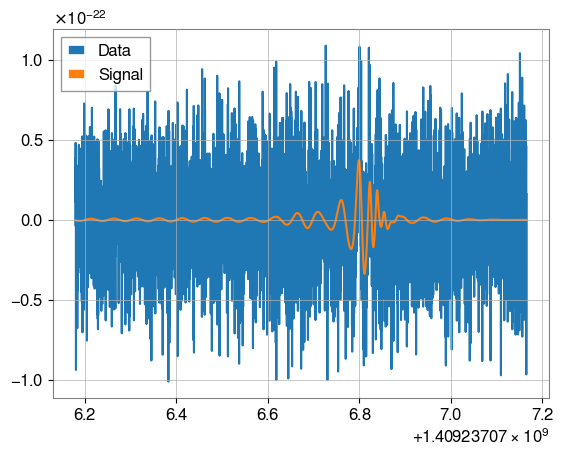

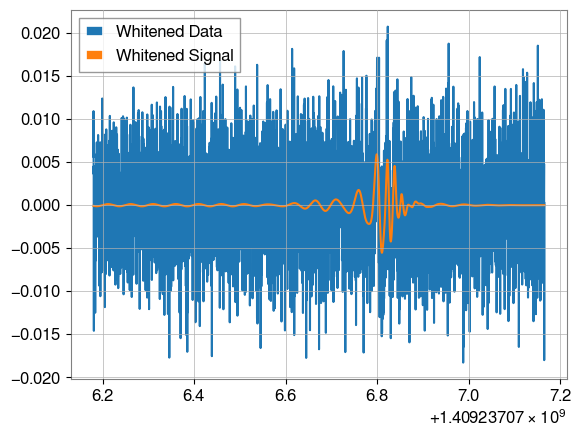

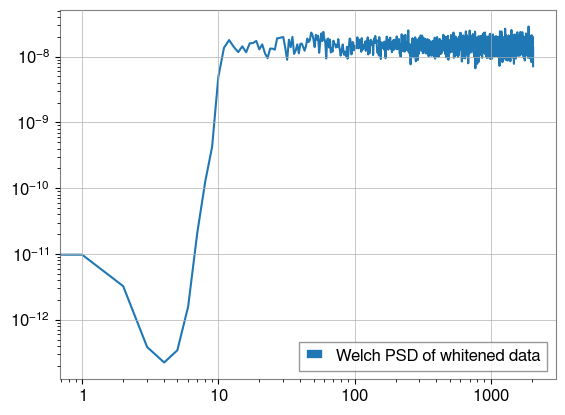

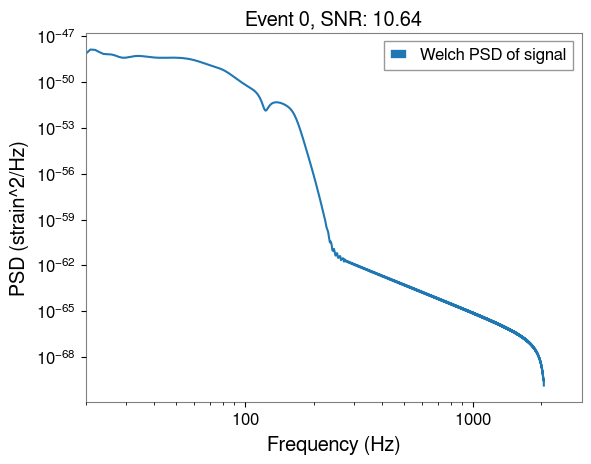

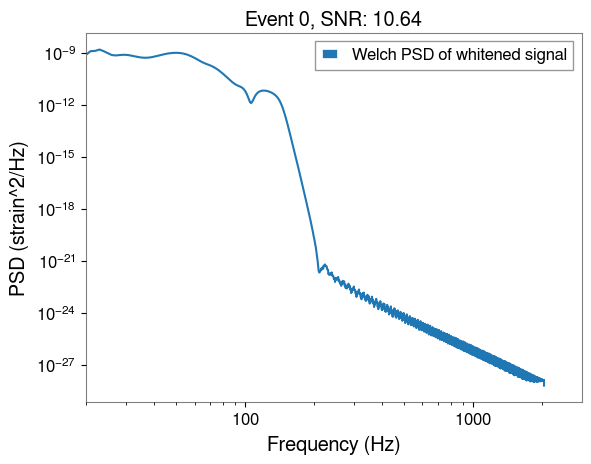

In [16]:
# Calculates the whitened data by dividing the frequency domain data by
# ((amplitude spectral density) * (duration / 4) ** 0.5). The resulting
# data will have unit variance.

i=0
d_tt=data[i]
tt=t[i]
h_tt=h[i]
d_t_w=data_whiten[i]
h_t_w=h_whiten[i]
j=61500
plt.figure()
plt.plot(tt[j:], d_tt[j:], label='Data')
plt.plot(tt[j:], h_tt[j:], label='Signal')
plt.legend()

plt.figure()
plt.plot(tt[j:], d_t_w[j:], label='Whitened Data')
plt.plot(tt[j:], h_t_w[j:], label='Whitened Signal')
# plt.plot(tt, d_t_w, label='White Data')
# plt.plot(tt, h_t_w, label='White Signal')
plt.legend()


# N = len(h_tt)
# window = tukey(N, alpha=0.01)   # alpha 调整尾部平滑比例
# d_t_windowed = d_tt * window
# h_t_windowed = h_tt * window

# f_psd, Pxx = welch(d_tt, fs=sampling_frequency, nperseg=sampling_frequency,window="tukey")
# plt.figure()
# plt.loglog(f_psd, Pxx, label='PSD of d(t)')
# d_f=np.fft.rfft(d_tt)
# h_f=np.fft.rfft(h_tt)
# fr = np.fft.rfftfreq(N, d=1/sampling_frequency)
# Pxx_interp = np.interp(fr, f_psd, Pxx)



# d_f_white = d_f/((np.sqrt(Pxx_interp) * np.sqrt(duration/4)))
# h_f_white = h_f/((np.sqrt(Pxx_interp) * np.sqrt(duration/4)))

# # 回到时域
# d_t_white = np.fft.irfft(d_f_white, n=len(d_tt))
# h_t_white = np.fft.irfft(h_f_white, n=len(h_tt))

# # 归一化到单位方差
# d_std = np.std(d_t_white)
# d_t_white /= d_std
# h_t_white /= d_std 


# plt.figure()
# plt.plot(tt[63500:], d_t_white[63500:], label='White Data')
# plt.plot(tt[63500:], h_t_white[63500:], label='White Signal')
# # plt.plot(tt, d_t_white, label='White Data')
# plt.legend()

f_psd_white, Pxx_white = welch(d_t_w, fs=sampling_frequency, nperseg=sampling_frequency, window="tukey" )
plt.figure()
plt.loglog(f_psd_white, Pxx_white, label='Welch PSD of whitened data')
plt.legend()

f_welch, h_f_welch = welch(h_t, fs=sampling_frequency, nperseg=sampling_frequency, window="tukey")
plt.figure()
plt.loglog(f_welch, h_f_welch, label="Welch PSD of signal")
plt.title(f"Event {i}, SNR: {SNR[i]:.2f}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (strain^2/Hz)")
plt.xlim(20)
plt.legend()
plt.grid()
# print(max(np.sqrt(h_f_welch)))

f_welch, h_f_welch = welch(h_t_w, fs=sampling_frequency, nperseg=sampling_frequency, window="tukey")
plt.figure()
plt.loglog(f_welch, h_f_welch, label="Welch PSD of whitened signal")
plt.title(f"Event {i}, SNR: {SNR[i]:.2f}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (strain^2/Hz)")
plt.xlim(20)
plt.legend()
plt.grid()
# print(max(np.sqrt(h_f_welch)))

# print(np.argmax(SNR)))
print("Injection parameters for event", i)
print('geocent_time:', source_params.iloc[i]['geocent_time'])
# print(source_params.iloc[i])
print("Peak time:", tt[np.argmax(np.abs(h_t_w))])

geocent_time: 1368348720.8339772
Peak time: 1368348720.8339772

geocent_time: 1218220487.9156966
Peak time: 1218220487.9156966

geocent_time: 1234084767.1232193
Peak time: 1234084767.1232193

geocent_time: 1381821549.2463508
Peak time: 1381821549.2463508

geocent_time: 1136757189.8019772
Peak time: 1136757189.8019772

geocent_time: 1181179822.0313792
Peak time: 1181179822.0313792

geocent_time: 1250211875.8503337
Peak time: 1250211875.8503337

geocent_time: 1278622938.171271
Peak time: 1278622938.171271

geocent_time: 1213871791.8433492
Peak time: 1213871791.8433492

geocent_time: 1378176537.4788015
Peak time: 1378176537.4788015



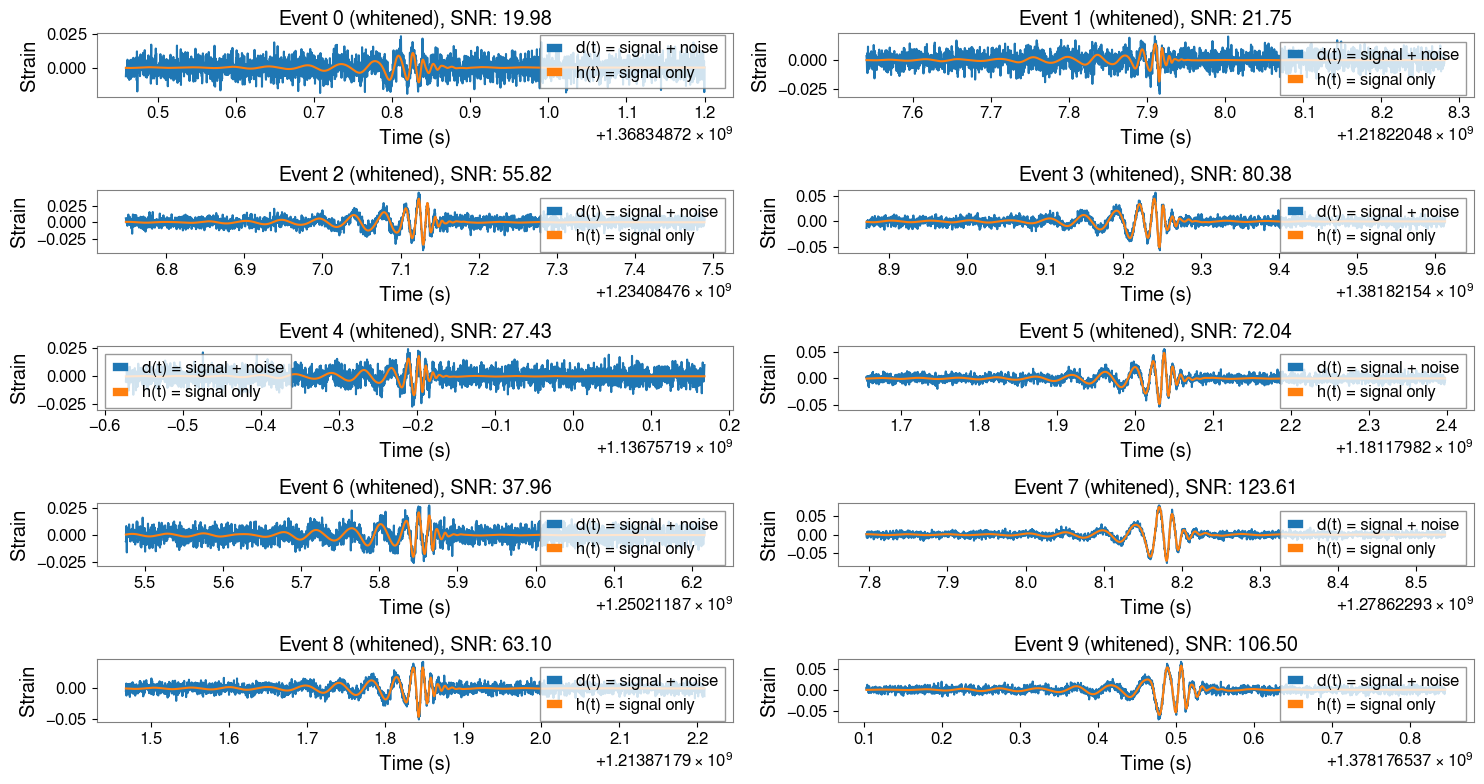

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(15, 8)) 
axs = axs.flatten()
for j in range(len(lensed_source_params)//2):  
    ax = axs[j]
    ax.plot(t_1[j][62500:], data_1_whiten[j][62500:], label="d(t) = signal + noise")
    ax.plot(t_1[j][62500:], h_1_whiten[j][62500:], label="h(t) = signal only")
    ax.set_title(f"Event {j} (whitened), SNR: {SNR_1[j]:.2f}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Strain")
    ax.legend()
    ax.grid()
    print('geocent_time:', lensed_source_params.iloc[j]['geocent_time'])
    print("Peak time:", t_1[j][np.argmax(np.abs(h_1_whiten[j]))])
    print()
for k in range(j+1, len(axs)):
    fig.delaxes(axs[k])


plt.tight_layout()
plt.show()

geocent_time: 1377102885.2638216
Peak time: 1377102885.2638216

geocent_time: 1226004111.73975
Peak time: 1226004111.73975

geocent_time: 1240897850.3414814
Peak time: 1240897850.3414814

geocent_time: 1387664091.858822
Peak time: 1387664091.858822

geocent_time: 1141629191.8086574
Peak time: 1141629191.8086574

geocent_time: 1185081283.4322684
Peak time: 1185081283.4322684

geocent_time: 1253142796.6454318
Peak time: 1253142796.6454318

geocent_time: 1280583318.3605783
Peak time: 1280583318.3605783

geocent_time: 1214861631.426865
Peak time: 1214861631.426865

geocent_time: 1378195836.4565265
Peak time: 1378195836.4565265



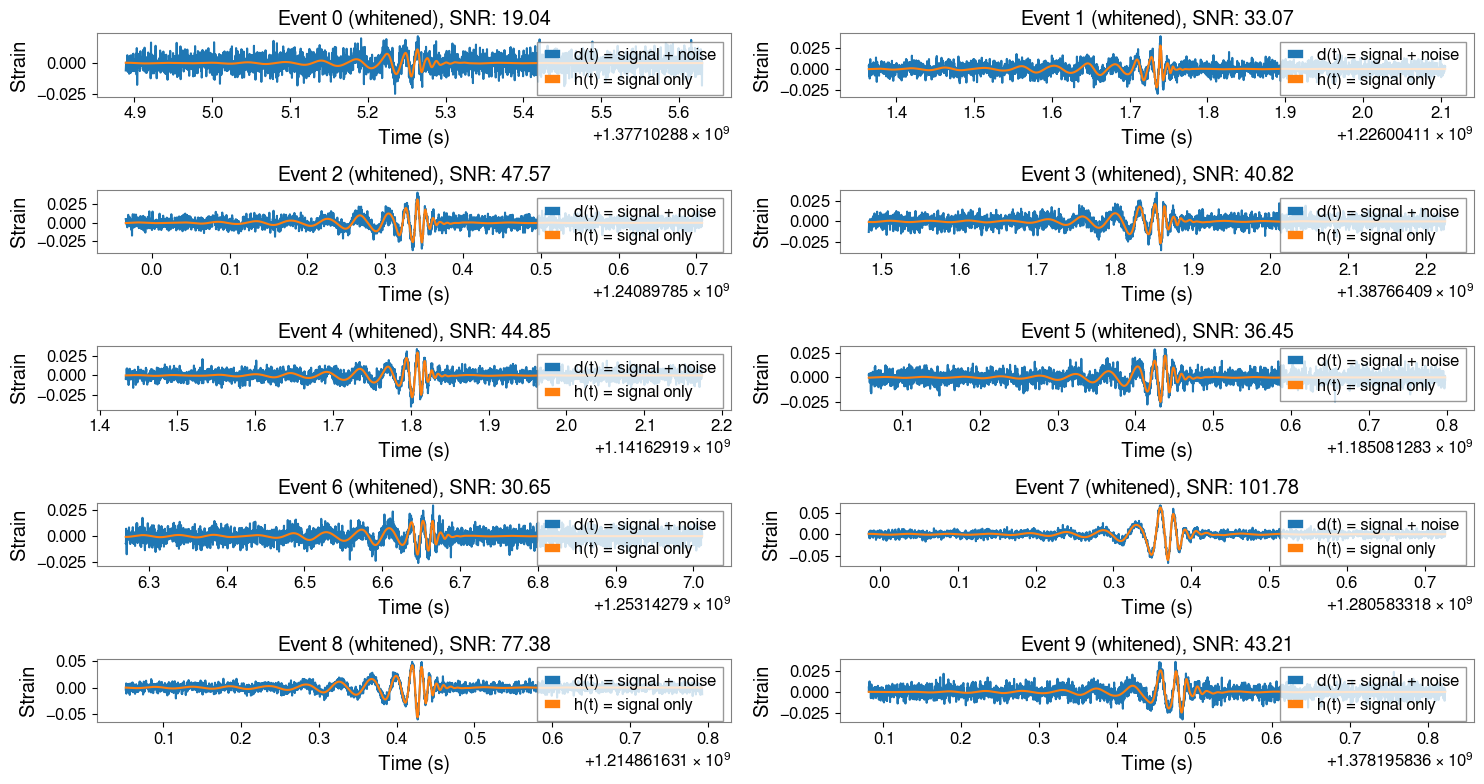

In [22]:
fig, axs = plt.subplots(5, 2, figsize=(15, 8)) 
axs = axs.flatten()
for j in range(len(lensed_source_params)//2):  
    ax = axs[j]
    ax.plot(t_2[j][62500:], data_2_whiten[j][62500:], label="d(t) = signal + noise")
    ax.plot(t_2[j][62500:], h_2_whiten[j][62500:], label="h(t) = signal only")
    ax.set_title(f"Event {j} (whitened), SNR: {SNR_2[j]:.2f}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Strain")
    ax.legend()
    ax.grid()
    print('geocent_time:', lensed_source_params.iloc[j+len(lensed_source_params)//2]['geocent_time'])
    print("Peak time:", t_2[j][np.argmax(np.abs(h_2_whiten[j]))])
    print()
for k in range(j+1, len(axs)):
    fig.delaxes(axs[k])


plt.tight_layout()
plt.show()